In [ ]:
import time
import pickle
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.compat.v1 as tfc

from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

In [30]:
try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tf.compat.v1.ConfigProto(log_device_placement=True))

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Device mapping: no known devices.
Num GPUs Available:  0


SystemError: GPU device not found

## Adjust CSV

In [31]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
full_img = list(map('train_images/'.__add__, images))
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


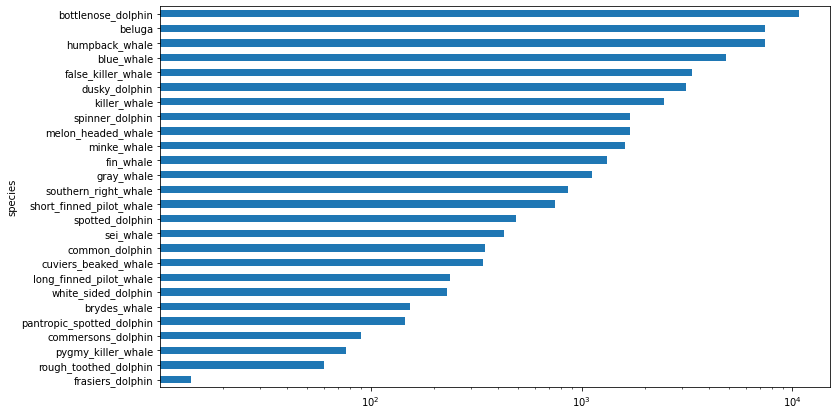

In [32]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [33]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)
labels = train_df["species"]

##one-hot encode species
#train_df = pd.concat([train_df, pd.get_dummies(train_df["species"],prefix='species_',drop_first=True)], axis = 1)
#train_df.drop(['species'],axis=1, inplace=True)
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Input Pipeline

In [34]:
IMG_SIZE = 64
BATCH_SIZE = 64
AMT_CLASSES = len(train_df.species.unique())

In [35]:
    """
    @tf.function
    def process_img(img):
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.convert_image_dtype(img, tf.float32) / 255
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bicubic', preserve_aspect_ratio=False, antialias=False,) 
        return img #tf.image.per_image_standardization(img)


    def opencv_process_img(path):
        file_name = tf.strings.split(path, "\\")[-1].numpy().decode()
        image = cv2.imread("train_images/"+file_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return tf.convert_to_tensor(image, dtype=tf.float32)



    def get_label(path):
        file_name= tf.strings.split(path, "\\")[-1]
        label= train_df[train_df["image"]==file_name]["species"].to_numpy().squeeze()
        return tf.convert_to_tensor(label)


    def process_path(path):
        if device_name != '/device:GPU:0':
            with tf.device('/cpu:0'):  
                img = process_img(tf.io.read_file(path))
        else:
            with tf.device('/device:GPU:0'):  
                img = process_img(tf.io.read_file(path))

        #img = opencv_process_img(path)
        label = get_label(path)
        return img, label
    """
    
    @tf.function
    def process_tuple(image,label):
        img = tf.io.read_file(image)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32) / 255
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bicubic', preserve_aspect_ratio=False,antialias=False)
        return img, label

In [36]:
#dataset = tf.data.Dataset.list_files('train_images/*').map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]))
#dataset = tf.data.Dataset.list_files('train_images/*').map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]),num_parallel_calls=tf.data.AUTOTUNE)

dataset = tf.data.Dataset.from_tensor_slices((full_img, labels)).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).shuffle(BATCH_SIZE)

In [37]:
image_count = dataset.cardinality().numpy()
train_size = int(image_count*0.7)
val_test_size = int((1-train_size)/2)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_test_size)
test_ds = dataset.skip(train_size).skip(val_test_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(BATCH_SIZE)
val_batched = val_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(BATCH_SIZE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(BATCH_SIZE)

### Benchmark Dataset

In [38]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [39]:
benchmark_ds = dataset.take(1)
benchmark(benchmark_ds)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]

Execution time: 7.35822829999961


## Sequential Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               6291968   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 26)                1690      
                                                                 
Total params: 6,466,138
Trainable params: 6,466,138
No

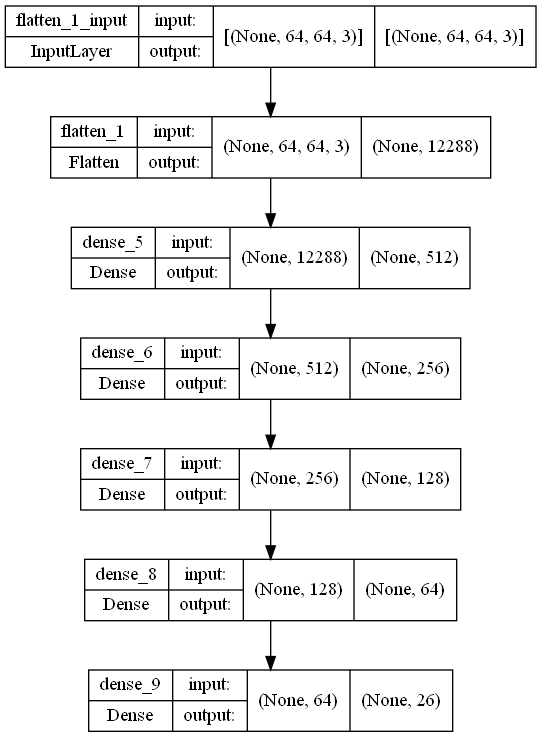

In [40]:
#generating model
model = keras.Sequential([
    layers.Flatten(input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(26, activation="softmax"),
])
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

In [41]:
#compiling model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [ ]:
model.fit(train_batched, epochs=25, validation_data = val_batched)

Epoch 1/25
231/559 [===========>..................] - ETA: 15:41 - loss: 3.0623 - sparse_categorical_accuracy: 0.2088

In [ ]:
model.evaluate(test_batched)

In [ ]:
with open('base_model', 'wb') as file:
    pickle.dump(model,file)

## CNN

In [ ]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    data_augmentation = keras.Sequential(
        [
            #version tf 2.4.1: 
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.1),
        ]
    )
    # Image augmentation block
    x = data_augmentation(inputs)
    activation_str = "elu"
    # Entry block
    #version tf 2.4.1
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    #-----------------
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(activation_str)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation_str)(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [ ]:
#creating model
cnnmodel = create_model([IMG_SIZE, IMG_SIZE, 3], AMT_CLASSES)
cnnmodel.summary()
plot_model(cnnmodel,show_shapes=True, show_layer_names=True)

In [ ]:
#compiling model
cnnmodel.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [ ]:
if device_name != '/device:GPU:0':
    with tf.device('/cpu:0'):  
        cnnmodel.fit(train_batched, epochs = 15, validation_data = val_batched)
else:
    with tf.device('/device:GPU:0'):  
        cnnmodel.fit(train_batched, epochs = 15, validation_data = val_batched)



In [ ]:
cnnmodel.evaluate(test_batched)

In [ ]:
with open('cnn_model', 'wb') as file:
    pickle.dump(cnnmodel,file)